### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,confusion_matrix
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import json
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
from google.colab import drive, files

# drive.mount('/content/drive/')

In [4]:
file = files.upload()

Saving toxic_comments.csv to toxic_comments.csv


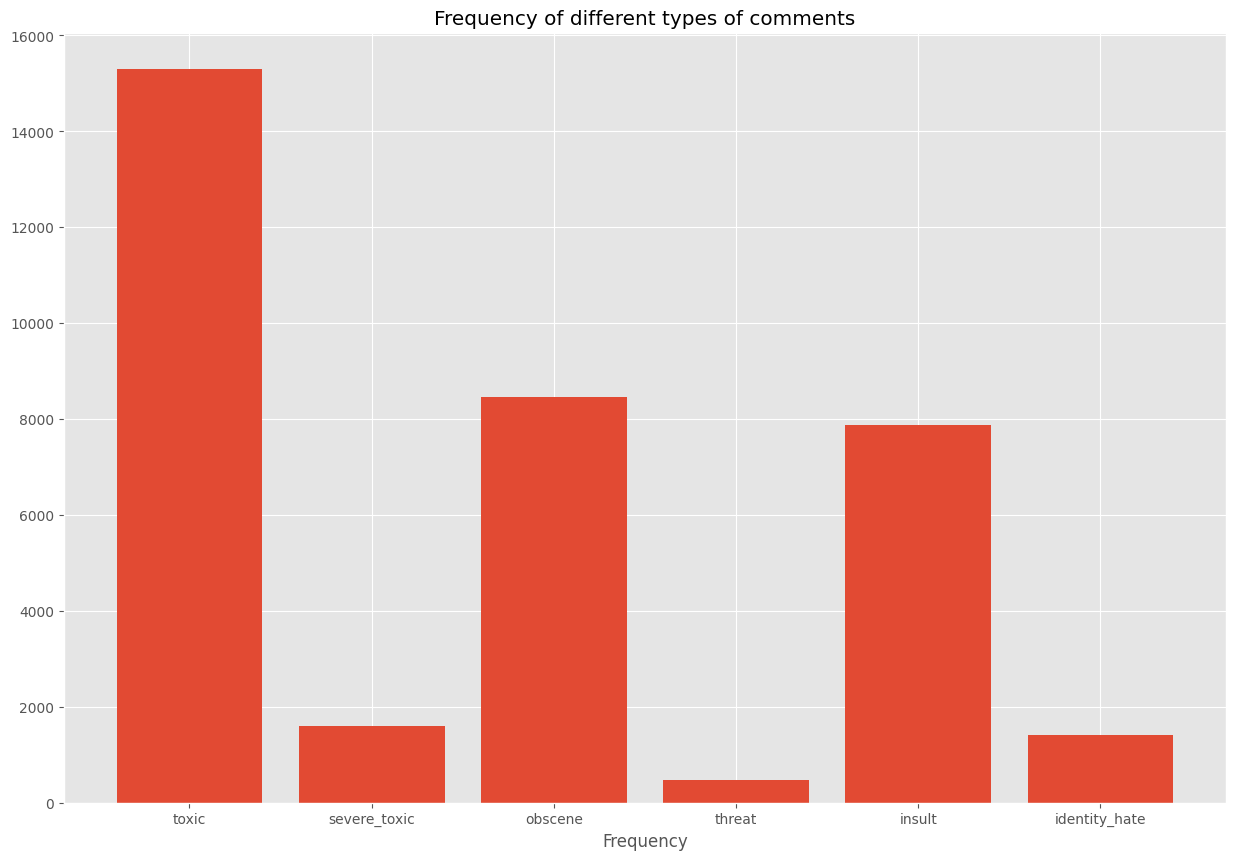

In [33]:
warnings.filterwarnings('ignore')
df = pd.read_csv('toxic_comments.csv')
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

x= df[cols_target].sum().index
y = df[cols_target].sum()
plt.bar(x,y)
plt.xlabel("Frequency")
plt.title("Frequency of different types of comments")
plt.show()

In [6]:
# cleaning the text so that the filler words are removed

def clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r'[-()"#/@;:{}`+=~|.!?,]', "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("(\W)"," ",text)
    text = re.sub('S*dS*s*','', text)
    return text

df["text"] = df['comment_text'].apply(lambda text: clean_text(text))

In [7]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
X_train, X_test, y_train, y_test = train_test_split(df['text'], df[cols_target], test_size= 0.3)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(111699,)
(111699, 6)
(47872,)
(47872, 6)


In [9]:
# vectorization using TFIDF(Term Frequency Inverse Document Frequency)

vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'w{1,}',
    ngram_range=(1, 3),
    stop_words='english',
    sublinear_tf=True,
    max_features = 118)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [10]:
model = OneVsRestClassifier(MultinomialNB())
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

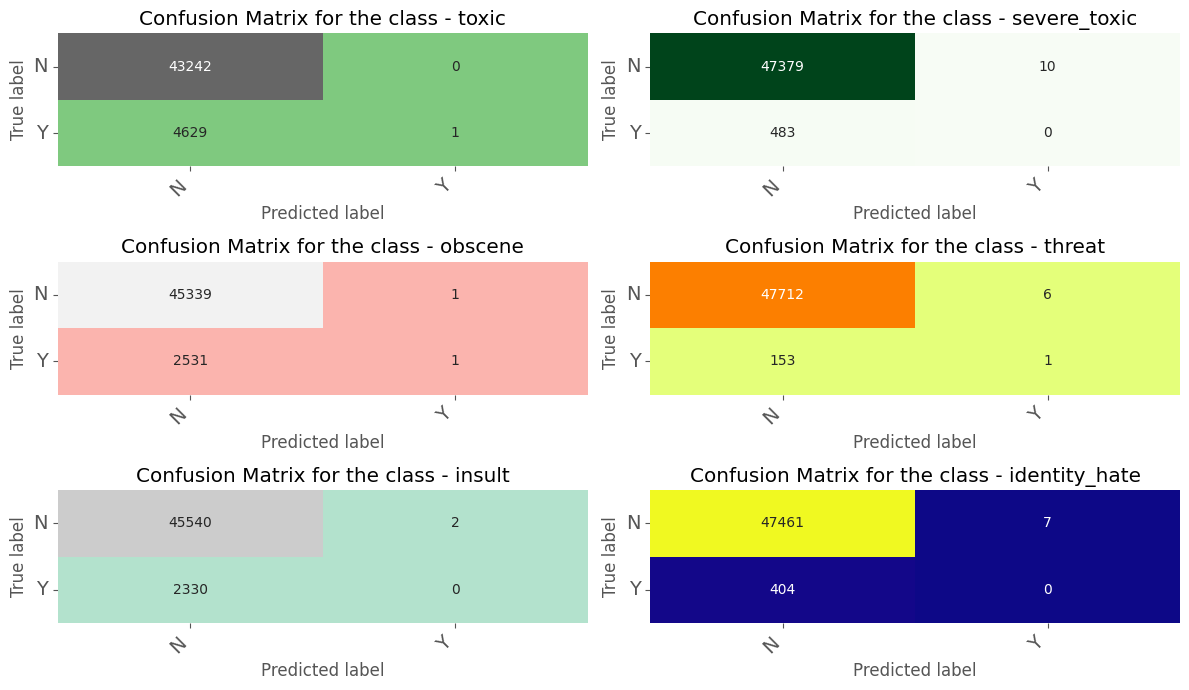

In [11]:
cfs = []
for i in range(6):
    cf = np.asarray(confusion_matrix(y_test[cols_target[i]], y_pred[:,i]))
    cfs.append(cf)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names,c,fontsize=14):

  df_cm = pd.DataFrame(

        confusion_matrix, index=class_names, columns=class_names,

    )


  heatmap = sns.heatmap(df_cm, annot=True,cmap=c, fmt="d", cbar=False, ax=axes)


  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)

  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

  axes.set_ylabel('True label')

  axes.set_xlabel('Predicted label')

  axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(3, 2, figsize=(12, 7))

cmaps = ['Accent','Greens','Pastel1','Wistia','Pastel2','plasma']

for axes, cfs_matrix, label, i in zip(ax.flatten(), cfs, cols_target,range(6)):

    c = cmaps[i]

    print_confusion_matrix(cfs_matrix, axes, label,["N", "Y"],c,14)

fig.tight_layout()

plt.show()

### Predicting toxicity of caption present in the memes

In [12]:
# this file can be found the hateful_memes folder

file_2 = files.upload()

Saving train.jsonl to train.jsonl


In [13]:
f = open('train.jsonl', 'r')
json_data = [json.loads(line) for line in f]

In [14]:
hateful_captions = []

for dict in json_data:
  if dict['label'] == 1:
    hateful_captions.append(dict['text'])

dict = {'captions':hateful_captions}
memes_df = pd.DataFrame(dict)

memes_df

,captions
0,tattoos are bad for your health i know 5 milli...
1,jew mad? get fuhrerious!
2,brother... a day without a blast is a day wasted
3,if there is no race it can't be homicide
4,when you come home from a long day of suicide ...
...,...
3014,nobody wants to hang auschwitz me
3015,when god grants you a child after 20 years of ...
3016,gays on social media: equality! body positivit...
3017,having a bad day? you could be a siamese twin ...


In [25]:
memes_df["clean_text"] = memes_df['captions'].apply(lambda text: clean_text(text))

In [26]:
transformed_captions = vect.transform(memes_df["clean_text"])

In [27]:
capt_pred = model.predict(transformed_captions)

In [32]:
comments_sentiment = capt_pred.sum(axis = 0)

for sentiment in enumerate(cols_target):
  print(f"Number of memes having {sentiment[1]} captions = {comments_sentiment[sentiment[0]]}")

Number of memes having toxic captions = 0
Number of memes having severe_toxic captions = 0
Number of memes having obscene captions = 0
Number of memes having threat captions = 0
Number of memes having insult captions = 0
Number of memes having identity_hate captions = 0


Some of the comments may be toxic but clearly the distribution of the data is different. The model is trained on toxic comments from social media whereas we are testing our model with captions from the memes which comes from a totally different distribution.

In the training data the comments were very lengthy but the captions were very small compared to the comments.

Clearly the captions are not enough to analyze the toxicity of the comments.

Features from images and the captions are to be combined to understand the toxicity of the memes better.